## Problem Statement

Happy Customer Bank is a mid-sized private bank that deals in all kinds of banking products, like Savings accounts, Current accounts, investment products, credit products, among other offerings.



The bank also cross-sells products to its existing customers and to do so they use different kinds of communication like tele-calling, e-mails, recommendations on net banking, mobile banking, etc. 



In this case, the Happy Customer Bank wants to cross sell its credit cards to its existing customers. The bank has identified a set of customers that are eligible for taking these credit cards.



Now, the bank is looking for your help in identifying customers that could show higher intent towards a recommended credit card, given:

- Customer details (gender, age, region etc.)
- Details of his/her relationship with the bank (Channel_Code,Vintage, 'Avg_Asset_Value etc.)

### Step 1: Importing the relevant libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

### Step 2: Data Inspection

In [2]:
train = pd.read_csv("train_s3TEQDk.csv")
test = pd.read_csv("test_mSzZ8RL.csv")

In [3]:
train.shape, test.shape

((245725, 11), (105312, 10))

* __We have 245725 rows and 11 columns in train set while 105312 rows and 10 columns in test set.__

In [4]:
# percentage of null values in train set
train.isnull().sum()/len(train)*100

ID                      0.000000
Gender                  0.000000
Age                     0.000000
Region_Code             0.000000
Occupation              0.000000
Channel_Code            0.000000
Vintage                 0.000000
Credit_Product         11.934073
Avg_Account_Balance     0.000000
Is_Active               0.000000
Is_Lead                 0.000000
dtype: float64

In [5]:
# percentage of null values in test set
test.isnull().sum()/len(test)*100

ID                      0.000000
Gender                  0.000000
Age                     0.000000
Region_Code             0.000000
Occupation              0.000000
Channel_Code            0.000000
Vintage                 0.000000
Credit_Product         11.890383
Avg_Account_Balance     0.000000
Is_Active               0.000000
dtype: float64

* __We have 12% (approx.) of missing values in Credit_Product column.__

In [6]:
# Checking the type of each column
train.info()
print("")
print("*************************************")
print("")
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB

*************************************

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105312 entries, 0 to 105311
Data columns (total 10 columns):
 #   Column               Non-Null Co

* __We have 7 categorical features and 4 numerical features in train set while 7 categorical features and 3 numerical features in test set.__

### Step 3: Data Cleaning

We will do the missing values treatment for the "Credit_Product" column.

In [7]:
train.isnull().sum()

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64

In [8]:
test.isnull().sum()

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         12522
Avg_Account_Balance        0
Is_Active                  0
dtype: int64

- As we also saw above, 'Credit_Product' has some missing values in the data.

#### 3.1 Credit_Product

In [9]:
print(train['Credit_Product'].value_counts())
print("*************************")
print(test['Credit_Product'].value_counts())

No     144357
Yes     72043
Name: Credit_Product, dtype: int64
*************************
No     61608
Yes    31182
Name: Credit_Product, dtype: int64


* __Since "Credit_Product" is a categorical column, we can impute the missing values by "Mode" (Most Repeated Value) in the column.__

In [10]:
train['Credit_Product'] = train['Credit_Product'].fillna(train['Credit_Product'].mode()[0])
test['Credit_Product'] = test['Credit_Product'].fillna(test['Credit_Product'].mode()[0])

In [11]:
train['Credit_Product'].isnull().sum(), test['Credit_Product'].isnull().sum()

(0, 0)

* __We have successfully imputed the missing values in the column 'Credit_Product'.__

### Step 4: Exploratory Data Analysis

In [12]:
train.columns

Index(['ID', 'Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active',
       'Is_Lead'],
      dtype='object')

In [13]:
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


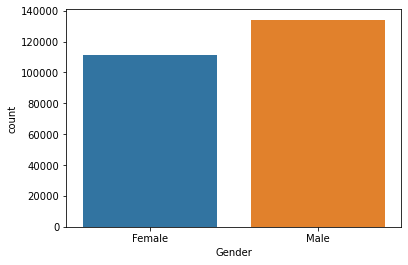

In [14]:
sns.countplot('Gender', data=train)
plt.show()

#### There are more males than females.

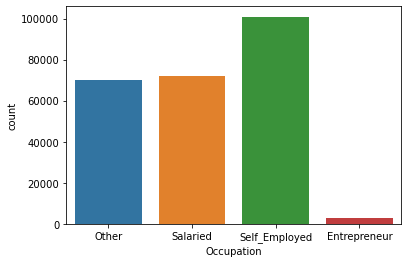

In [15]:
sns.countplot(x='Occupation', data=train)
plt.show()

#### The self-employed people are more in number than others. The secong highest number of people are salaried ones.

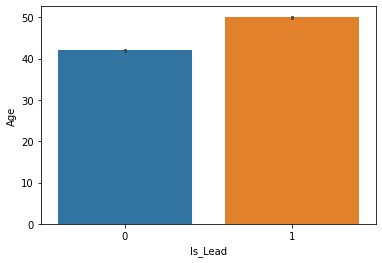

In [16]:
sns.barplot(x='Is_Lead', y='Age', data=train)
plt.show()

#### The average age of people who are interested for the credit card is around 50 years while the average age of people who are not interested for the credit card is around 40 years. 

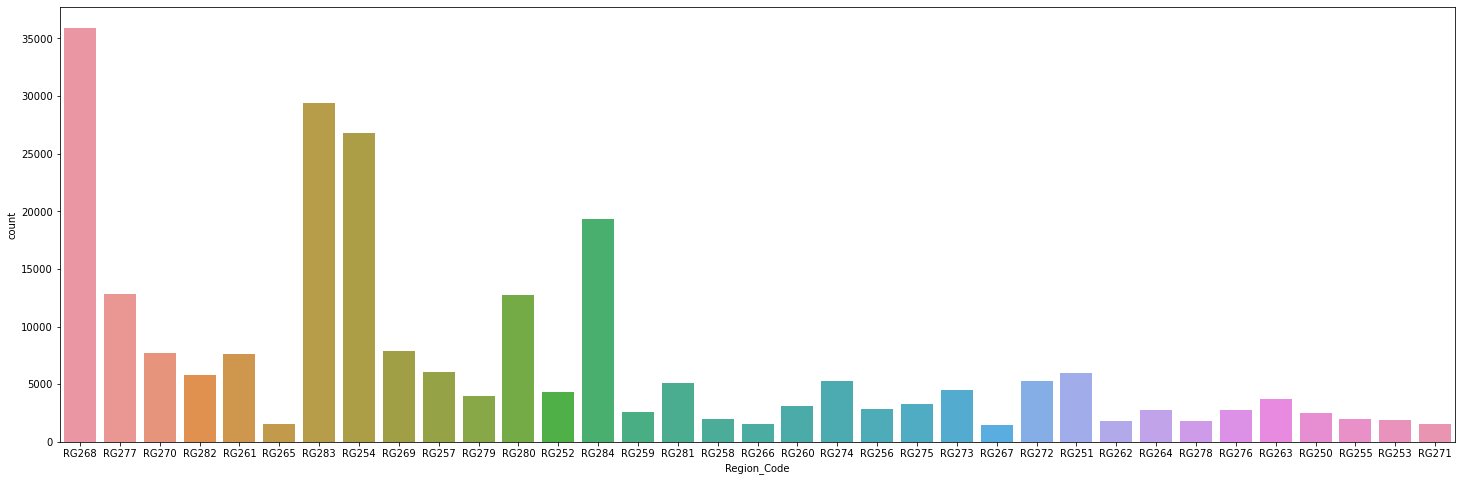

In [17]:
plt.figure(figsize=(25,8))
sns.countplot(x='Region_Code', data=train)
plt.show()

#### The highest number of customers belong to region 'RG268'.

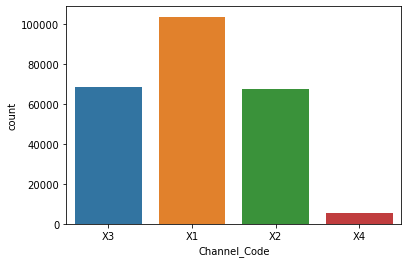

In [18]:
sns.countplot(x='Channel_Code', data=train)
plt.show()

#### The highest number of customers are acquired through channel 'X1' while the lowest number of customers are acquired through channel 'X4'.

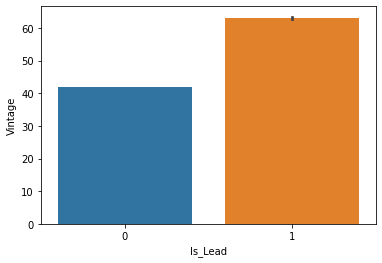

In [19]:
sns.barplot(x='Is_Lead', y='Vintage', data=train)
plt.show()

#### The customers who are interested for the credit card have an average vintage of around 60 months while the customers who are not interested for the credit card have an average vintage of around 40 months.

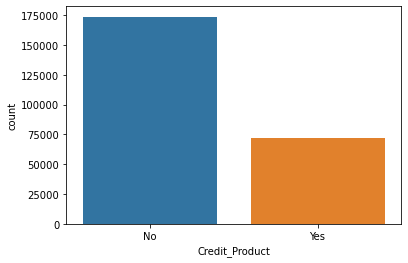

In [20]:
sns.countplot('Credit_Product', data=train)
plt.show()

#### Most of the customers do not have any active credit product.

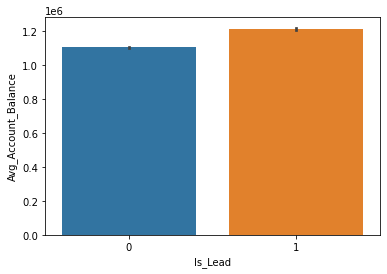

In [21]:
sns.barplot(x='Is_Lead', y='Avg_Account_Balance', data=train)
plt.show()

#### The customers who are interested for the credit card have higher average account balance than the customers who are not interested for the credit card.

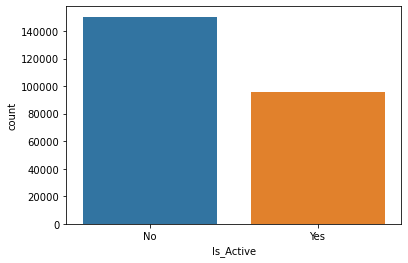

In [22]:
sns.countplot('Is_Active', data=train)
plt.show()

#### Less customers are active in last 3 months.

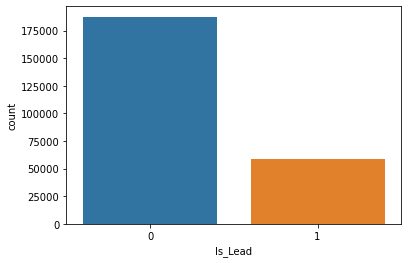

In [23]:
sns.countplot('Is_Lead', data=train)
plt.show()

#### The customers who are interested for the credit card are less than the customers who are not interested for the credit card.

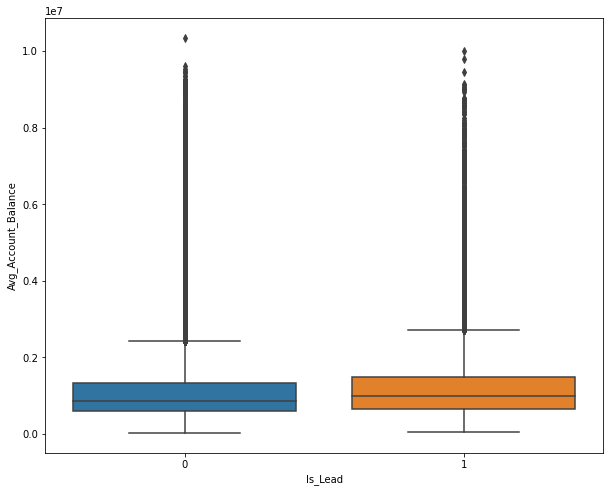

In [24]:
plt.figure(figsize=(10,8))
sns.boxplot(x='Is_Lead', y='Avg_Account_Balance', data=train)
plt.show()

In [25]:
# Checking for outliers in the continuous variables
train[['Age', 'Vintage', 'Avg_Account_Balance']].describe()

,Age,Vintage,Avg_Account_Balance
count,245725.000000,245725.000000,2.457250e+05
mean,43.856307,46.959141,1.128403e+06
std,14.828672,32.353136,8.529364e+05
min,23.000000,7.000000,2.079000e+04
25%,30.000000,20.000000,6.043100e+05
50%,43.000000,32.000000,8.946010e+05
75%,54.000000,73.000000,1.366666e+06
max,85.000000,135.000000,1.035201e+07


In [26]:
# Checking outliers at 25%, 50%, 75%, 90%, 95%, 99.5%, 99.8% for Avg_Account_Balance in train set
train.Avg_Account_Balance.describe(percentiles=[.25, .5, .75, .90, .95, .99, .995, .998])

count    2.457250e+05
mean     1.128403e+06
std      8.529364e+05
min      2.079000e+04
25%      6.043100e+05
50%      8.946010e+05
75%      1.366666e+06
90%      2.043591e+06
95%      2.673533e+06
99%      4.472873e+06
99.5%    5.604702e+06
99.8%    7.024243e+06
max      1.035201e+07
Name: Avg_Account_Balance, dtype: float64

In [27]:
# Checking outliers at 25%, 50%, 75%, 90%, 95%, 99.5%, 99.8% for Avg_Account_Balance in test set
test.Avg_Account_Balance.describe(percentiles=[.25, .5, .75, .90, .95, .99, .995, .998])

count    1.053120e+05
mean     1.134195e+06
std      8.662430e+05
min      2.259700e+04
25%      6.039822e+05
50%      8.966345e+05
75%      1.371598e+06
90%      2.057077e+06
95%      2.699587e+06
99%      4.601080e+06
99.5%    5.733408e+06
99.8%    7.103419e+06
max      9.908858e+06
Name: Avg_Account_Balance, dtype: float64

#### From the distribution shown above, we can see that there are no outliers in the train and test data. The numbers are gradually increasing.

### Step 5: Feature Engineering

In [28]:
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


#### Converting some binary variables (Yes/No) to 0/1

In [29]:
# List of variables to map

varlist = ['Credit_Product', 'Is_Active']

# Defining the map function
def binary_map(x):
    return x.map({'Yes':1, 'No':0})

# Applying the function to train and test set
train[varlist] = train[varlist].apply(binary_map)
test[varlist] = test[varlist].apply(binary_map)

In [30]:
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,0,1045696,0,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,0,581988,0,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,0,1484315,1,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,0,470454,0,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,0,886787,0,0


#### One-Hot Coding of Categorical variables

In [31]:
# One-Hot Coding for train set:
train = pd.get_dummies(train, columns=['Gender', 'Region_Code', 'Occupation', 'Channel_Code'])

# One-Hot Coding for test set:
test = pd.get_dummies(test, columns=['Gender', 'Region_Code', 'Occupation', 'Channel_Code'])

### Step 6: Train-Test Split

In [32]:
train.columns

Index(['ID', 'Age', 'Vintage', 'Credit_Product', 'Avg_Account_Balance',
       'Is_Active', 'Is_Lead', 'Gender_Female', 'Gender_Male',
       'Region_Code_RG250', 'Region_Code_RG251', 'Region_Code_RG252',
       'Region_Code_RG253', 'Region_Code_RG254', 'Region_Code_RG255',
       'Region_Code_RG256', 'Region_Code_RG257', 'Region_Code_RG258',
       'Region_Code_RG259', 'Region_Code_RG260', 'Region_Code_RG261',
       'Region_Code_RG262', 'Region_Code_RG263', 'Region_Code_RG264',
       'Region_Code_RG265', 'Region_Code_RG266', 'Region_Code_RG267',
       'Region_Code_RG268', 'Region_Code_RG269', 'Region_Code_RG270',
       'Region_Code_RG271', 'Region_Code_RG272', 'Region_Code_RG273',
       'Region_Code_RG274', 'Region_Code_RG275', 'Region_Code_RG276',
       'Region_Code_RG277', 'Region_Code_RG278', 'Region_Code_RG279',
       'Region_Code_RG280', 'Region_Code_RG281', 'Region_Code_RG282',
       'Region_Code_RG283', 'Region_Code_RG284', 'Occupation_Entrepreneur',
       'Occupation_

In [33]:
train.shape

(245725, 52)

In [34]:
train = train.select_dtypes(exclude='object')
test = test.select_dtypes(exclude='object')

In [35]:
# Separate Features and Target
X = train.drop(columns=['Is_Lead'], axis=1)
y = train['Is_Lead']

In [36]:
# Taking 20% data as validation set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=22)

### Step 7: Feature Scaling

In [37]:
# Standardisation of variables of X_train set
scaler = StandardScaler()

X_train[['Age', 'Vintage', 'Avg_Account_Balance']] = scaler.fit_transform(X_train[['Age', 'Vintage', 'Avg_Account_Balance']])

X_train.head()

,Age,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Gender_Female,Gender_Male,Region_Code_RG250,Region_Code_RG251,Region_Code_RG252,...,Region_Code_RG283,Region_Code_RG284,Occupation_Entrepreneur,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X1,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4
110911,2.035350,1.363487,0,-0.539883,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
242765,1.832888,2.353252,0,7.912399,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
93325,-1.069075,-0.616044,0,-0.623380,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
150490,0.753088,-0.801624,0,-0.300410,1,1,0,0,0,0,...,0,1,0,0,0,1,1,0,0,0
227007,-0.191738,-0.646974,0,-0.663548,1,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0


In [38]:
# Standardisation of variables of test set
scaler = StandardScaler()

test[['Age', 'Vintage', 'Avg_Account_Balance']] = scaler.fit_transform(test[['Age', 'Vintage', 'Avg_Account_Balance']])

test.head()

,Age,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Gender_Female,Gender_Male,Region_Code_RG250,Region_Code_RG251,Region_Code_RG252,...,Region_Code_RG283,Region_Code_RG284,Occupation_Entrepreneur,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X1,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4
0,-0.999878,-0.676804,1,-0.452333,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,-0.058563,0.066841,0,-0.240878,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,-0.865404,-1.017641,0,-1.060037,0,0,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0
3,-0.999878,-0.428922,0,-0.307219,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,-0.999878,-0.862715,0,-0.550781,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0


In [39]:
# Checking the lead generation rate from the train set
lead = (sum(train['Is_Lead'])/len(train['Is_Lead']))*100
lead

23.720826126767726

### Step 8: Looking at Correlations

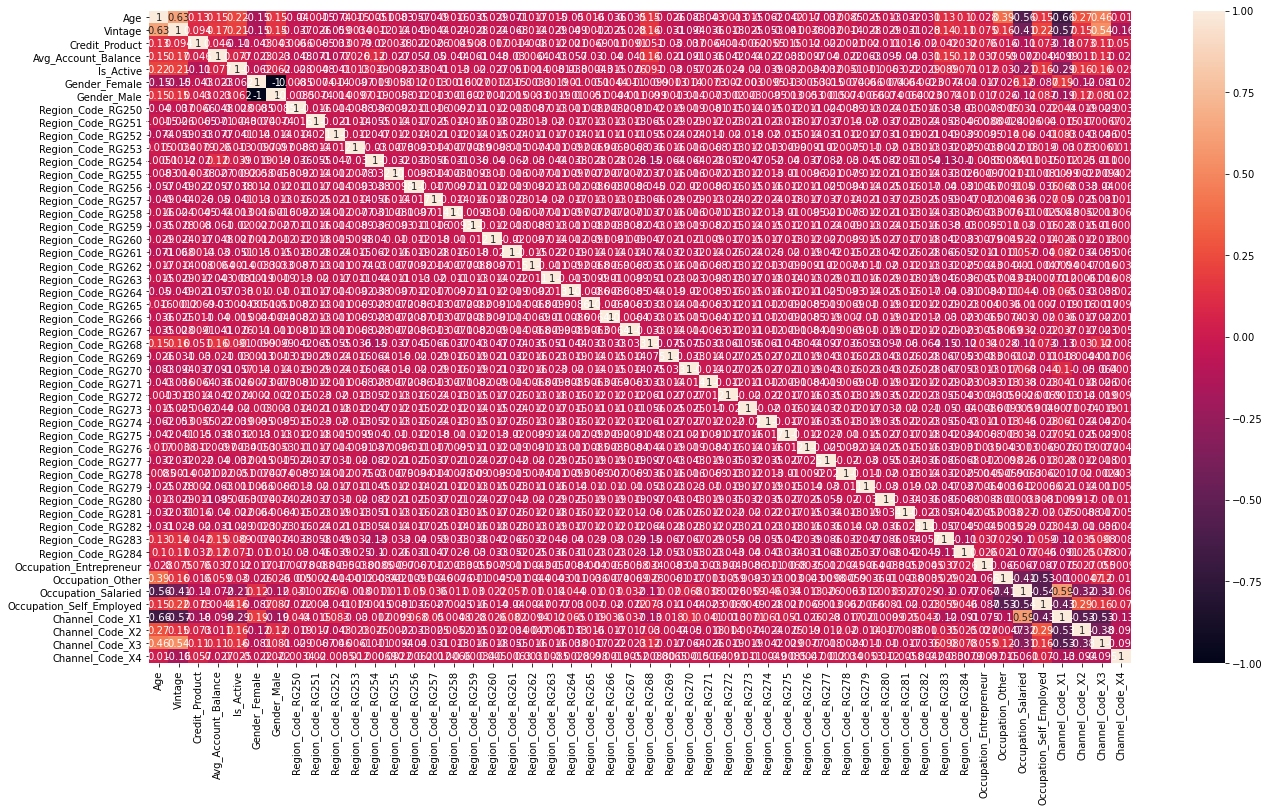

In [40]:
# Looking at the correlation matrix to check multicollinearity between the variables
plt.figure(figsize = (22,12))
sns.heatmap(X_train.corr(),annot = True)
plt.show()

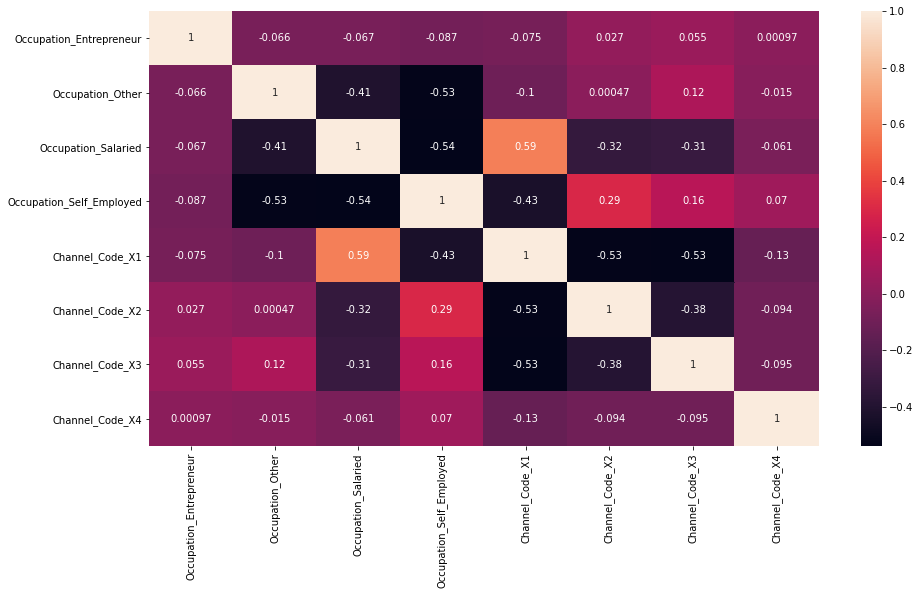

In [41]:
# Checking the correlation matrix for some dummy variables
plt.figure(figsize = (15,8))
sns.heatmap(X_train[['Occupation_Entrepreneur', 'Occupation_Other', 'Occupation_Salaried', 'Occupation_Self_Employed', 'Channel_Code_X1', 'Channel_Code_X2', 'Channel_Code_X3', 'Channel_Code_X4']].corr(),annot = True)
plt.show()

#### Dropping the highly correlated dummy variables

In [42]:
X_train = X_train.drop(['Channel_Code_X1', 'Occupation_Salaried'], axis=1)

X_valid = X_valid.drop(['Channel_Code_X1', 'Occupation_Salaried'], axis=1)

test = test.drop(['Channel_Code_X1', 'Occupation_Salaried'], axis=1)

#### Checking the Correlation Matrix

After droppping the highly correlated variables, we are checking the correlation matrix again.

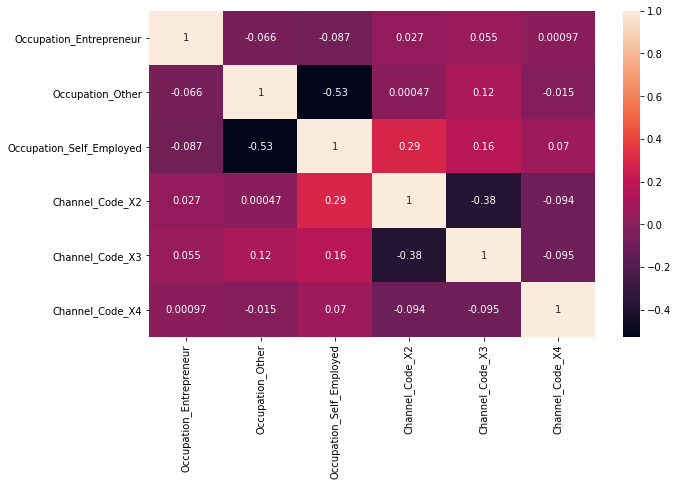

In [43]:
plt.figure(figsize = (10,6))
sns.heatmap(X_train[['Occupation_Entrepreneur', 'Occupation_Other', 'Occupation_Self_Employed', 'Channel_Code_X2', 'Channel_Code_X3', 'Channel_Code_X4']].corr(),annot = True)
plt.show()

### Step 9: Feature Selection using RFE

In [44]:
logreg = LogisticRegression()

In [45]:
# Running RFE with 15 variables as output
rfe = RFE(logreg, 15)      
rfe = rfe.fit(X_train, y_train)

In [46]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('Age', False, 3),
 ('Vintage', True, 1),
 ('Credit_Product', True, 1),
 ('Avg_Account_Balance', False, 34),
 ('Is_Active', False, 23),
 ('Gender_Female', False, 18),
 ('Gender_Male', False, 25),
 ('Region_Code_RG250', True, 1),
 ('Region_Code_RG251', False, 33),
 ('Region_Code_RG252', False, 2),
 ('Region_Code_RG253', False, 28),
 ('Region_Code_RG254', True, 1),
 ('Region_Code_RG255', False, 6),
 ('Region_Code_RG256', False, 19),
 ('Region_Code_RG257', False, 15),
 ('Region_Code_RG258', False, 24),
 ('Region_Code_RG259', False, 32),
 ('Region_Code_RG260', False, 22),
 ('Region_Code_RG261', False, 30),
 ('Region_Code_RG262', True, 1),
 ('Region_Code_RG263', False, 12),
 ('Region_Code_RG264', True, 1),
 ('Region_Code_RG265', False, 16),
 ('Region_Code_RG266', True, 1),
 ('Region_Code_RG267', True, 1),
 ('Region_Code_RG268', False, 11),
 ('Region_Code_RG269', False, 14),
 ('Region_Code_RG270', False, 20),
 ('Region_Code_RG271', False, 26),
 ('Region_Code_RG272', False, 31),
 ('Region_Co

In [47]:
col = X_train.columns[rfe.support_]

### Step 10: Model Building

#### Assessing the model with StatsModels

In [48]:
X_train_sm = sm.add_constant(X_train[col])
logm1 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm1.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                Is_Lead   No. Observations:               196580
Model:                            GLM   Df Residuals:                   196564
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -94846.
Date:                Wed, 09 Jun 2021   Deviance:                   1.8969e+05
Time:                        14:04:03   Pearson chi2:                 1.99e+05
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -1.8102      0.015   -123.882      0.000      -1.839      -1.782
Vintage                      0.3902      0.007     56.369      0.000       0.377       0.404
Credit_Product               0.3362      0.012     27.958      0.000       0.313       0.360
Region_Code_RG250           -0.2227      0.065     -3.420      0.001      -0.350      -0.095
Region_Code_RG254           -0.2046      0.019    -10.922      0.000      -0.241      -0.168
Region_Code_RG262           -0.2735      0.073     -3.758      0.000      -0.416      -0.131
Region_Code_RG264           -0.2114      0.066     -3.222      0.001      -0.340      -0.083
Region_Code_RG266           -0.3514      0.086     -4.092      0.000      -0.520      -0.183
Region_Code_RG267           -0.2420      0.084     -2.893      0.004      -0.406      -0.078
Region_Code_RG278           -0.2879      0.067     -4.286      0.000      -0.420      -0.156
Occupation_Entrepreneur      0.5830      0.051     11.366      0.000       0.482       0.684
Occupation_Other            -0.8181      0.020    -40.493      0.000      -0.858      -0.779
Occupation_Self_Employed    -0.8451      0.020    -42.850      0.000      -0.884      -0.806
Channel_Code_X2              1.6603      0.021     80.586      0.000       1.620       1.701
Channel_Code_X3              1.5514      0.022     71.269      0.000       1.509       1.594
Channel_Code_X4              1.6835      0.039     42.745      0.000       1.606       1.761
============================================================================================
"""

#### All the 15 variables seem significant as their respective p-values are less than 0.05. We will now check the Variance Inflation Factor (VIF) for these variables.

In [49]:
# Checking for the VIF values of the feature variables
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Creating a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
11,Occupation_Self_Employed,2.99
13,Channel_Code_X3,2.97
12,Channel_Code_X2,2.55
10,Occupation_Other,1.89
0,Vintage,1.44
1,Credit_Product,1.42
14,Channel_Code_X4,1.12
3,Region_Code_RG254,1.10
9,Occupation_Entrepreneur,1.07
2,Region_Code_RG250,1.01


#### All variables have a good value of VIF. So we need not drop any variable and we can proceed with making predictions using this model only.

In [50]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

110911    0.367045
242765    0.410147
93325     0.091744
150490    0.048891
227007    0.223154
120062    0.389875
78986     0.100166
208310    0.088314
158399    0.104602
125270    0.317567
dtype: float64

In [51]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.36704454, 0.41014665, 0.0917442 , 0.04889105, 0.22315413,
       0.38987471, 0.10016606, 0.08831407, 0.1046019 , 0.31756711])

#### Creating a dataframe with the actual Is_Lead flag and the predicted probabilities

In [52]:
y_train_pred_final = pd.DataFrame({'Is_Lead':y_train.values, 'Lead_Prob':y_train_pred})
y_train_pred_final['ID'] = y_train.index
y_train_pred_final.head()

,Is_Lead,Lead_Prob,ID
0,0,0.367045,110911
1,0,0.410147,242765
2,1,0.091744,93325
3,1,0.048891,150490
4,0,0.223154,227007


#### We will now firstly find the optimal cutoff point or optimal cutoff probability which is the probability where we get balanced sensitivity and specificity.

In [53]:
# Creating columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Lead_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Is_Lead,Lead_Prob,ID,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.367045,110911,1,1,1,1,0,0,0,0,0,0
1,0,0.410147,242765,1,1,1,1,1,0,0,0,0,0
2,1,0.091744,93325,1,0,0,0,0,0,0,0,0,0
3,1,0.048891,150490,1,0,0,0,0,0,0,0,0,0
4,0,0.223154,227007,1,1,1,0,0,0,0,0,0,0


In [54]:
# Calculating accuracy, sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Is_Lead, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.237059  1.000000  0.000000
0.1   0.1  0.425898  0.927727  0.269971
0.2   0.2  0.598062  0.804360  0.533961
0.3   0.3  0.700646  0.607154  0.729695
0.4   0.4  0.757559  0.320251  0.893438
0.5   0.5  0.775277  0.115148  0.980391
0.6   0.6  0.772769  0.053668  0.996206
0.7   0.7  0.766467  0.021051  0.998080
0.8   0.8  0.763343  0.002489  0.999753
0.9   0.9  0.762941  0.000000  1.000000


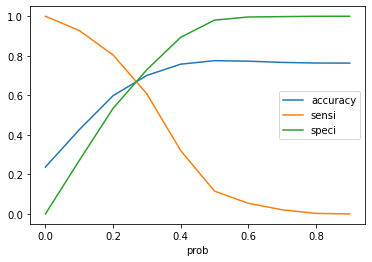

In [55]:
# Plotting accuracy, sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

#### From the above curve, 0.3 is the optimum point to take it as a cutoff probability.

In [56]:
y_train_pred_final = y_train_pred_final.drop([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 1)

In [57]:
y_train_pred_final['predicted'] = y_train_pred_final.Lead_Prob.map( lambda x: 1 if x > 0.3 else 0)

y_train_pred_final.head()

,Is_Lead,Lead_Prob,ID,predicted
0,0,0.367045,110911,1
1,0,0.410147,242765,1
2,1,0.091744,93325,0
3,1,0.048891,150490,0
4,0,0.223154,227007,0


In [58]:
# Taking a look at the confusion matrix
confusion = metrics.confusion_matrix(y_train_pred_final.Is_Lead, y_train_pred_final.predicted )
confusion

array([[109439,  40540],
       [ 18307,  28294]], dtype=int64)

In [59]:
# Checking the overall accuracy.
metrics.accuracy_score(y_train_pred_final.Is_Lead, y_train_pred_final.predicted)

0.7006460474107233

In [60]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [61]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.6071543529108817

In [62]:
# Let us calculate specificity
TN / float(TN+FP)

0.7296954907020317

#### Plotting the ROC curve

In [63]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [64]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Is_Lead, y_train_pred_final.Lead_Prob, drop_intermediate = False )

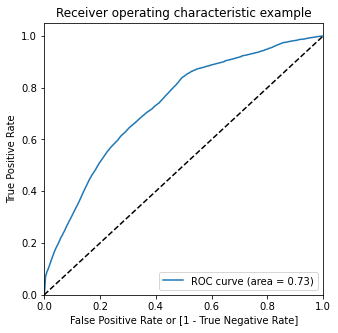

In [65]:
draw_roc(y_train_pred_final.Is_Lead, y_train_pred_final.Lead_Prob)

In [66]:
# Getting score for area under ROC curve on the train set
roc_auc_score(y_train_pred_final.Is_Lead, y_train_pred_final.Lead_Prob)

0.7326652034726133

### Step 11: Making predictions on the test validation set

In [67]:
X_valid[['Age', 'Vintage', 'Avg_Account_Balance']] = scaler.transform(X_valid[['Age', 'Vintage', 'Avg_Account_Balance']])

X_train.head()

,Age,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Gender_Female,Gender_Male,Region_Code_RG250,Region_Code_RG251,Region_Code_RG252,...,Region_Code_RG281,Region_Code_RG282,Region_Code_RG283,Region_Code_RG284,Occupation_Entrepreneur,Occupation_Other,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4
110911,2.035350,1.363487,0,-0.539883,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
242765,1.832888,2.353252,0,7.912399,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
93325,-1.069075,-0.616044,0,-0.623380,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
150490,0.753088,-0.801624,0,-0.300410,1,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
227007,-0.191738,-0.646974,0,-0.663548,1,0,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [68]:
X_valid = X_valid[col]
X_valid.head()

,Vintage,Credit_Product,Region_Code_RG250,Region_Code_RG254,Region_Code_RG262,Region_Code_RG264,Region_Code_RG266,Region_Code_RG267,Region_Code_RG278,Occupation_Entrepreneur,Occupation_Other,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4
127732,0.283737,1,0,0,0,0,0,0,0,0,0,1,1,0,0
111308,1.213293,1,0,0,0,0,0,0,0,0,1,0,0,1,0
158317,0.655559,0,0,0,0,0,0,0,0,0,1,0,0,1,0
234144,-0.831730,1,0,0,0,0,0,0,0,0,0,0,0,0,0
39335,-0.490893,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [69]:
X_valid_sm = sm.add_constant(X_valid)

Making predictions on the validation set.

In [70]:
y_valid_pred = res.predict(X_valid_sm)

y_valid_pred[:10]

127732    0.366316
111308    0.433558
158317    0.305522
234144    0.142028
39335     0.119022
26564     0.273201
222710    0.353539
183200    0.045117
159734    0.100185
230349    0.208902
dtype: float64

In [71]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_valid_pred)

In [72]:
# Let's see the head
y_pred_1.head()

,0
127732,0.366316
111308,0.433558
158317,0.305522
234144,0.142028
39335,0.119022


In [73]:
y_valid.head()

127732    0
111308    0
158317    1
234144    0
39335     1
Name: Is_Lead, dtype: int64

In [74]:
# Converting y_valid to dataframe
y_valid_df = pd.DataFrame(y_valid)

In [75]:
y_valid_df.head()

,Is_Lead
127732,0
111308,0
158317,1
234144,0
39335,1


In [76]:
# Putting CustID to index
y_valid_df['ID'] = y_valid_df.index

In [77]:
y_valid_df.head()

,Is_Lead,ID
127732,0,127732
111308,0,111308
158317,1,158317
234144,0,234144
39335,1,39335


In [78]:
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_valid_df.reset_index(drop=True, inplace=True)

In [79]:
# Concatenating y_valid_df and y_pred_1
y_pred_final = pd.concat([y_valid_df, y_pred_1],axis=1)

In [80]:
y_pred_final.head()

,Is_Lead,ID,0
0,0,127732,0.366316
1,0,111308,0.433558
2,1,158317,0.305522
3,0,234144,0.142028
4,1,39335,0.119022


In [81]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Lead_Prob'})

In [82]:
# Rearranging the columns
y_pred_final = y_pred_final.reindex(['ID','Is_Lead','Lead_Prob'], axis=1)

In [83]:
# Let's see the head of y_pred_final
y_pred_final.head()

,ID,Is_Lead,Lead_Prob
0,127732,0,0.366316
1,111308,0,0.433558
2,158317,1,0.305522
3,234144,0,0.142028
4,39335,1,0.119022


In [84]:
y_pred_final['final_predicted'] = y_pred_final.Lead_Prob.map(lambda x: 1 if x > 0.3 else 0)

In [85]:
y_pred_final.head()

,ID,Is_Lead,Lead_Prob,final_predicted
0,127732,0,0.366316,1
1,111308,0,0.433558,1
2,158317,1,0.305522,1
3,234144,0,0.142028,0
4,39335,1,0.119022,0


In [86]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.Is_Lead, y_pred_final.final_predicted)

0.6980567707803439

In [87]:
# Checking the roc_auc_score on the test validation set
roc_auc_score(y_pred_final.Is_Lead, y_pred_final.Lead_Prob)

0.7311991135670763

### Step 12: Making predictions on the test set

In [88]:
test = test[col]
test.head()

,Vintage,Credit_Product,Region_Code_RG250,Region_Code_RG254,Region_Code_RG262,Region_Code_RG264,Region_Code_RG266,Region_Code_RG267,Region_Code_RG278,Occupation_Entrepreneur,Occupation_Other,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4
0,-0.676804,1,0,1,0,0,0,0,0,0,1,0,0,0,0
1,0.066841,0,0,0,0,0,0,0,0,0,1,0,1,0,0
2,-1.017641,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-0.428922,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,-0.862715,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [89]:
test_sm = sm.add_constant(test)

In [90]:
test_pred = res.predict(test_sm)

In [91]:
# Converting test_pred to a dataframe which is an array
test_pred_1 = pd.DataFrame(test_pred)

In [92]:
# Let's see the head
test_pred_1.head()

,0
0,0.059478
1,0.280517
2,0.099101
3,0.057560
4,0.049037


In [93]:
test.head()

,Vintage,Credit_Product,Region_Code_RG250,Region_Code_RG254,Region_Code_RG262,Region_Code_RG264,Region_Code_RG266,Region_Code_RG267,Region_Code_RG278,Occupation_Entrepreneur,Occupation_Other,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4
0,-0.676804,1,0,1,0,0,0,0,0,0,1,0,0,0,0
1,0.066841,0,0,0,0,0,0,0,0,0,1,0,1,0,0
2,-1.017641,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-0.428922,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,-0.862715,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [94]:
test_final = pd.concat([test, test_pred_1],axis=1)

In [95]:
# Renaming the column 
test_final= test_final.rename(columns={ 0 : 'Lead_Prob'})

In [96]:
test_final.head()

,Vintage,Credit_Product,Region_Code_RG250,Region_Code_RG254,Region_Code_RG262,Region_Code_RG264,Region_Code_RG266,Region_Code_RG267,Region_Code_RG278,Occupation_Entrepreneur,Occupation_Other,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Lead_Prob
0,-0.676804,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0.059478
1,0.066841,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0.280517
2,-1.017641,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.099101
3,-0.428922,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.057560
4,-0.862715,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.049037


In [97]:
test_final['final_predicted'] = test_final.Lead_Prob.map(lambda x: 1 if x > 0.3 else 0)

test_final.head()

,Vintage,Credit_Product,Region_Code_RG250,Region_Code_RG254,Region_Code_RG262,Region_Code_RG264,Region_Code_RG266,Region_Code_RG267,Region_Code_RG278,Occupation_Entrepreneur,Occupation_Other,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Lead_Prob,final_predicted
0,-0.676804,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0.059478,0
1,0.066841,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0.280517,0
2,-1.017641,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.099101,0
3,-0.428922,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.057560,0
4,-0.862715,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.049037,0


### Step 13: Making the submission

In [98]:
submission = pd.read_csv('sample_submission_eyYijxG.csv')
final_predictions = test_final.Lead_Prob.map(lambda x: 1 if x > 0.3 else 0)
submission['Is_Lead'] = final_predictions

submission.to_csv('my_submission.csv', index=False)